In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

# EXTRACTING THE DATA

In [2]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'   # Contains dummy labels for test image

In [3]:
# creating a labels dict to help us out in the future
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [4]:
# lets create a pandas dataframe to simplify our work on train_csv
data_df = pd.read_csv(TRAIN_CSV)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19236 entries, 0 to 19235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   19236 non-null  int64 
 1   Label   19236 non-null  object
dtypes: int64(1), object(1)
memory usage: 300.7+ KB


In [5]:
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


We have multiple labels for each image

In [6]:
# we create to functions to convert our string label to a tensor label for the model to work with

def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

In [7]:
# we create a function to convert this tensor back into a string label

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [8]:
# lets try out these functions 
# indexing from 0
encode_label("5 8 1")

tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0.])

In [9]:
decode_target(torch.tensor([0,1,0,1,0,1,0,1,0,1]))

'1 3 5 7 9'

In [10]:
decode_target(torch.tensor([0,1,0,1,0,1,0,1,0,1]), text_labels = True)

'Nuclear bodies(1) Golgi apparatus(3) Nucleoli fibrillar center(5) Plasma membrane(7) Nuclear speckles(9)'

# Creating dataloaders/datasets

In [11]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

### Data Augmentations

In [12]:
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = T.Compose([T.RandomCrop(512, padding = 10, padding_mode='reflect'), T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), T.RandomHorizontalFlip(), T.ToTensor(), T.Normalize(*stats,inplace = True), T.RandomErasing(inplace = True)])

val_transform = T.Compose([T.ToTensor(),T.Normalize(*stats)])

In [13]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.80

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [14]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform = train_transform)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform = val_transform)

len(train_ds), len(val_ds)

(15397, 3839)

In [15]:
# now lets look at one of the images from the dataset
def show_sample(img, target, invert = True):
    
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
        
    print('Labels:', decode_target(target, text_labels=True))
    
# we change the indexing from 0,1,2 to 1,2,0 to plot using matplotlib

Labels: Nuclear speckles(9)


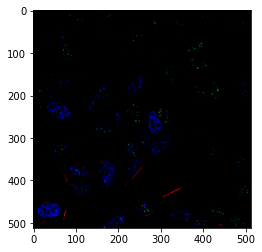

In [16]:
show_sample(*train_ds[0], invert = False)

Let's look at the image with the colors inverted

Labels: Nuclear speckles(9)


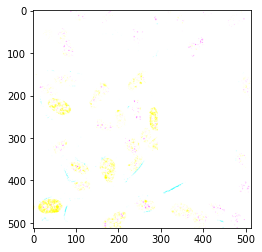

In [17]:
show_sample(*train_ds[0])

### Splitting the data into training and validation sets

In [18]:
#torch.manual_seed(10)

In [19]:
# using a validation percentage of 20%
#val = 0.2
#val_size = int(val * len(dataset))
#train_size = len(dataset) - val_size

In [20]:
#train_ds, val_ds = random_split(dataset, [train_size, val_size])#
#len(train_ds), len(val_ds)

## Forming dataloaders

In [21]:
# declaring batch size
batch_size = 32

In [22]:
# forming the train and validation dataloaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers = 3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 3, pin_memory=True)

In [23]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

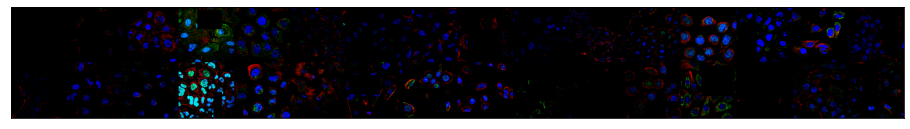

In [24]:
show_batch(train_dl, invert = False)

## Model

In [25]:
# defining the metrics 

def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [26]:
# creating the base model

class MultiImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        
        images, targets = batch 
        out = self(images)
        
        # using binary cross entropy loss function...
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        
        images, targets = batch 
        out = self(images)       # Generate predictions
        
        # using binary cross-entropy loss function
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [27]:
class ProteinCNN(MultiImageClassificationBase):
    
    # constructor function
    def __init__(self):
        
        super().__init__()
        
        # creating the network
        self.network = nn.Sequential(
            nn.Conv2d(3, 15, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(15, 60, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(60, 120, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(120, 90, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(90, 30, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(30, 15, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(240, 80),
            nn.ReLU(),
            
            nn.Linear(80, 10),
            nn.Softmax()
        )
        
    def forward(self, xb):
        
        return self.network(xb)

In [28]:
class ProteinCNN2(MultiImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        
        # Use a pretrained model
        self.network = models.resnet34(pretrained = True)
        
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [29]:
model = ProteinCNN2()
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ProteinCNN2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Getting the device i.e, GPU or CPU

In [30]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [31]:
# getting the gpu 
device = get_default_device()
device

device(type='cuda')

In [32]:
# transferring the dataloaders to the GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ProteinCNN2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [33]:
# making random predictions
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([32, 3, 512, 512])
out.shape: torch.Size([32, 10])
out[0]: tensor([0.4055, 0.4022, 0.5834, 0.3541, 0.4435, 0.6557, 0.4779, 0.3601, 0.6068,
        0.5888], device='cuda:0', grad_fn=<SelectBackward>)


## Training the model

In [34]:
# loads the epochs...
from tqdm.notebook import tqdm

In [35]:
# creating the evaluate and fit functions...

def evaluate(model, val_loader):
    
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, decay, opt_func, grad_clip = None):
    
    torch.cuda.empty_cache()
    history = []
    
    #setting up the optimizer
    optimizer = opt_func(model.parameters(), lr = max_lr, weight_decay = decay)
    
    # setting up the learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, steps_per_epoch = len(train_loader))
    
    for epoch in range(epochs):
        
        # Training Phase 
        model.train()
        
        train_losses = []
        
        lrs = []
        
        for batch in tqdm(train_loader):
            
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [36]:
# replacing the model into the gpu
model = to_device(ProteinCNN2(), device)

In [37]:
torch.cuda.empty_cache()
# evaluating the model which is randomized
evaluate(model, val_dl)

{'val_loss': 0.7977349162101746, 'val_score': 0.25123727321624756}

In [38]:
# freezing the model(only final layer is trained here) and training some epochs
model.freeze()

In [39]:
# setting up the hyperparams
num_epochs = 2
opt_func = torch.optim.Adamax
grad_clip = 1e-1
max_lr = 1e-2
decay = 1e-4

In [40]:
# training the model
torch.cuda.empty_cache()
history = []
history += fit(num_epochs, max_lr, model, train_dl, val_dl, decay, opt_func, grad_clip)


Epoch [0], last_lr: 0.0081, train_loss: 0.3329, val_loss: 0.3457, val_score: 0.4052



Epoch [1], last_lr: 0.0000, train_loss: 0.2791, val_loss: 0.2384, val_score: 0.6072


In [41]:
# unfreezing the model
torch.cuda.empty_cache()
model.unfreeze()

In [42]:
max_lr = 1e-3
num_epochs = 3
history += fit(num_epochs, max_lr, model, train_dl, val_dl, decay, opt_func, grad_clip)


Epoch [0], last_lr: 0.0010, train_loss: 0.2520, val_loss: 0.2392, val_score: 0.6321



Epoch [1], last_lr: 0.0005, train_loss: 0.2452, val_loss: 0.2241, val_score: 0.6589



Epoch [2], last_lr: 0.0000, train_loss: 0.2259, val_loss: 0.2060, val_score: 0.6966


## Submissions and Predictions on the test dataset

In [56]:
# function to predict a single image

def predict_single(image):
    
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [57]:
# loading the test dataset
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform = val_transform)

In [58]:
# looking at one of the images in the test dataset
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([0.0040, 0.0200, 0.0380, 0.0109, 0.9783, 0.0077, 0.8071, 0.0554, 0.0267,
        0.0031], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


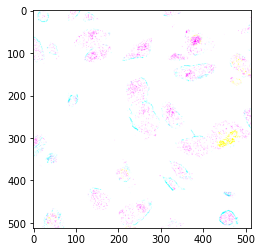

In [59]:
# prediction on discrete images
predict_single(test_dataset[100][0])

Prediction:  tensor([0.8174, 0.0211, 0.0194, 0.0770, 0.2226, 0.0094, 0.1443, 0.0134, 0.0142,
        0.0041], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Mitochondria(0)


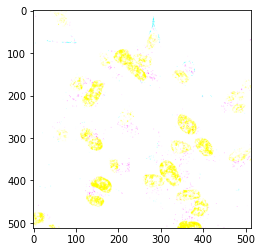

In [60]:
predict_single(test_dataset[74][0])

In [61]:
# getting the dataloader from the dataset
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True), device)

In [62]:
# getting the predictions for the entire test data loader
def predict_dl(dl, model):
    
    torch.cuda.empty_cache()
    batch_probs = []
    
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
        
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [63]:
test_preds = predict_dl(test_dl, model)

In [64]:
# updating submission.csv
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

,Image,Label
0,24117,4
1,15322,4
2,14546,6
3,8079,6
4,13192,4


In [65]:
sub_fname = 'resnet34_submission_1.csv'

In [66]:
# storing our submission into a .csv file
submission_df.to_csv(sub_fname, index=False)

In [67]:
!pip install jovian --upgrade

import jovian

jovian.commit(project='zerogans-protein-competition')

     |████████████████████████████████| 94 kB 1.9 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=7c4e607ebe88f5aaae78440e3ff4ed23ba543c4a79b05f8267015dd8ad900c06
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/chethan0hebbar/zerogans-protein-competition


<IPython.core.display.Javascript object>